## Evaluating the  Models 

### Primary Goal: Evaluate the ML and BL models

In this notebook, I'll provide a brief tutorial on how to evaluate the final machine learning (ML) and baseline (BL) models. 

In [15]:
# Import packages 
import pandas as pd
import numpy as np
from os.path import join
import joblib
import matplotlib.pyplot as plt

# We add the github package to our system path so we can import python scripts for that repo. 
import sys
#sys.path.append('/home/monte.flora/python_packages/2to6_hr_severe_wx/')
sys.path.append('/home/samuel.varga/projects/2to6_hr_severe_wx/')
sys.path.append('/home/samuel.varga/python_packages/ml_workflow/')
from main.io import load_ml_data, load_bl_data
from main.verification import plot_verification 

In [16]:
# Configuration variables (You'll need to change based on where you store your data)
data_path = '/work/samuel.varga/data/2to6_hr_severe_wx'

<div class="alert alert-block alert-danger"> <b>CAUTION</b> We are evaluating the models, so mode must be set to 'test' in load_ml_data or load_bl_data </div>

### Step 1. Load the ML and Baseline Testing Datasets

In [17]:
# Set the target column 
target_col='wind_severe__36km'
# Set the mode == test so as to load the testing dataset. 
mode='test'

# Load the testing dataset for the ML model.
X, y, metadata = load_ml_data(base_path=data_path, 
                            mode=mode, 
                            target_col=target_col)

# Load the testing dataset for the baseline model. 
# The baseline and machine learning models are 
# using the same target values so we do not need 
# initialize the baseline target values. 
bl_df, _, _ = load_bl_data(base_path=data_path, 
                             mode=mode, 
                             target_col=target_col, 
                            )
bl_col = {'hail_severe' :  'hailcast__nmep_>1_0_45km',
          'wind_severe' : 'ws_80__nmep_>40_45km',
          'tornado_severe' : 'uh_2to5_instant__nmep_>175_45km'
         }


# Get the X input into the baseline model. 
X_bl = bl_df[bl_col[target_col.split('__')[0]]]

### Step 2. Load the ML and Baseline models. 

In [18]:
#base_path = f'/work/mflora/ML_2TO6HR/models/'
base_path=f'/work/samuel.varga/projects/2to6_hr_severe_wx/'

# Load the baseline model. 
#bl_model = joblib.load(join(base_path,f'{target_col.split("_")[0]}_baseline_model_2_36km.joblib'))
bl_model = joblib.load(join(base_path,f'blModels/{target_col.split("_")[0]}_baseline_model.joblib'))
# Load the ML model.
ml_data = joblib.load(join(base_path, f'mlModels/Varga_{target_col}_model_hist_2.joblib')) #First Model (Hist)

# When the ML model is saved by the CalibratedPipelineHyperOptCV package, 
# there are additional metadata that is stored with it. 
# We want to load the model and the features. 
# We want to make sure the X input as the features in correct order. 
ml_model = ml_data['model']
features = ml_data['features']

ml_models = [ml_model] 

for name in ['logistic', 'random']: #Adds the Logistic and random models to the list
    ml_data = joblib.load(join(base_path, f'mlModels/Varga_{target_col}_model_{name}_2.joblib'))
    ml_model = ml_data['model']
    ml_models.append(ml_model)
    
names = ['Hist', 'Logistic', 'Random']
estimators = [(name, model) for name, model in zip(names, ml_models)]

X = X[features]

### Step 3. Evaluate the ML and Baseline models using Reliability, Performance, and ROC Diagrams

/home/samuel.varga/miniconda3/envs/Vanilla/lib/python3.10/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/samuel.varga/miniconda3/envs/Vanilla/lib/python3.10/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/samuel.varga/miniconda3/envs/Vanilla/lib/python3.10/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/samuel.varga/miniconda3/envs/Vanilla/lib/python3.10/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shap

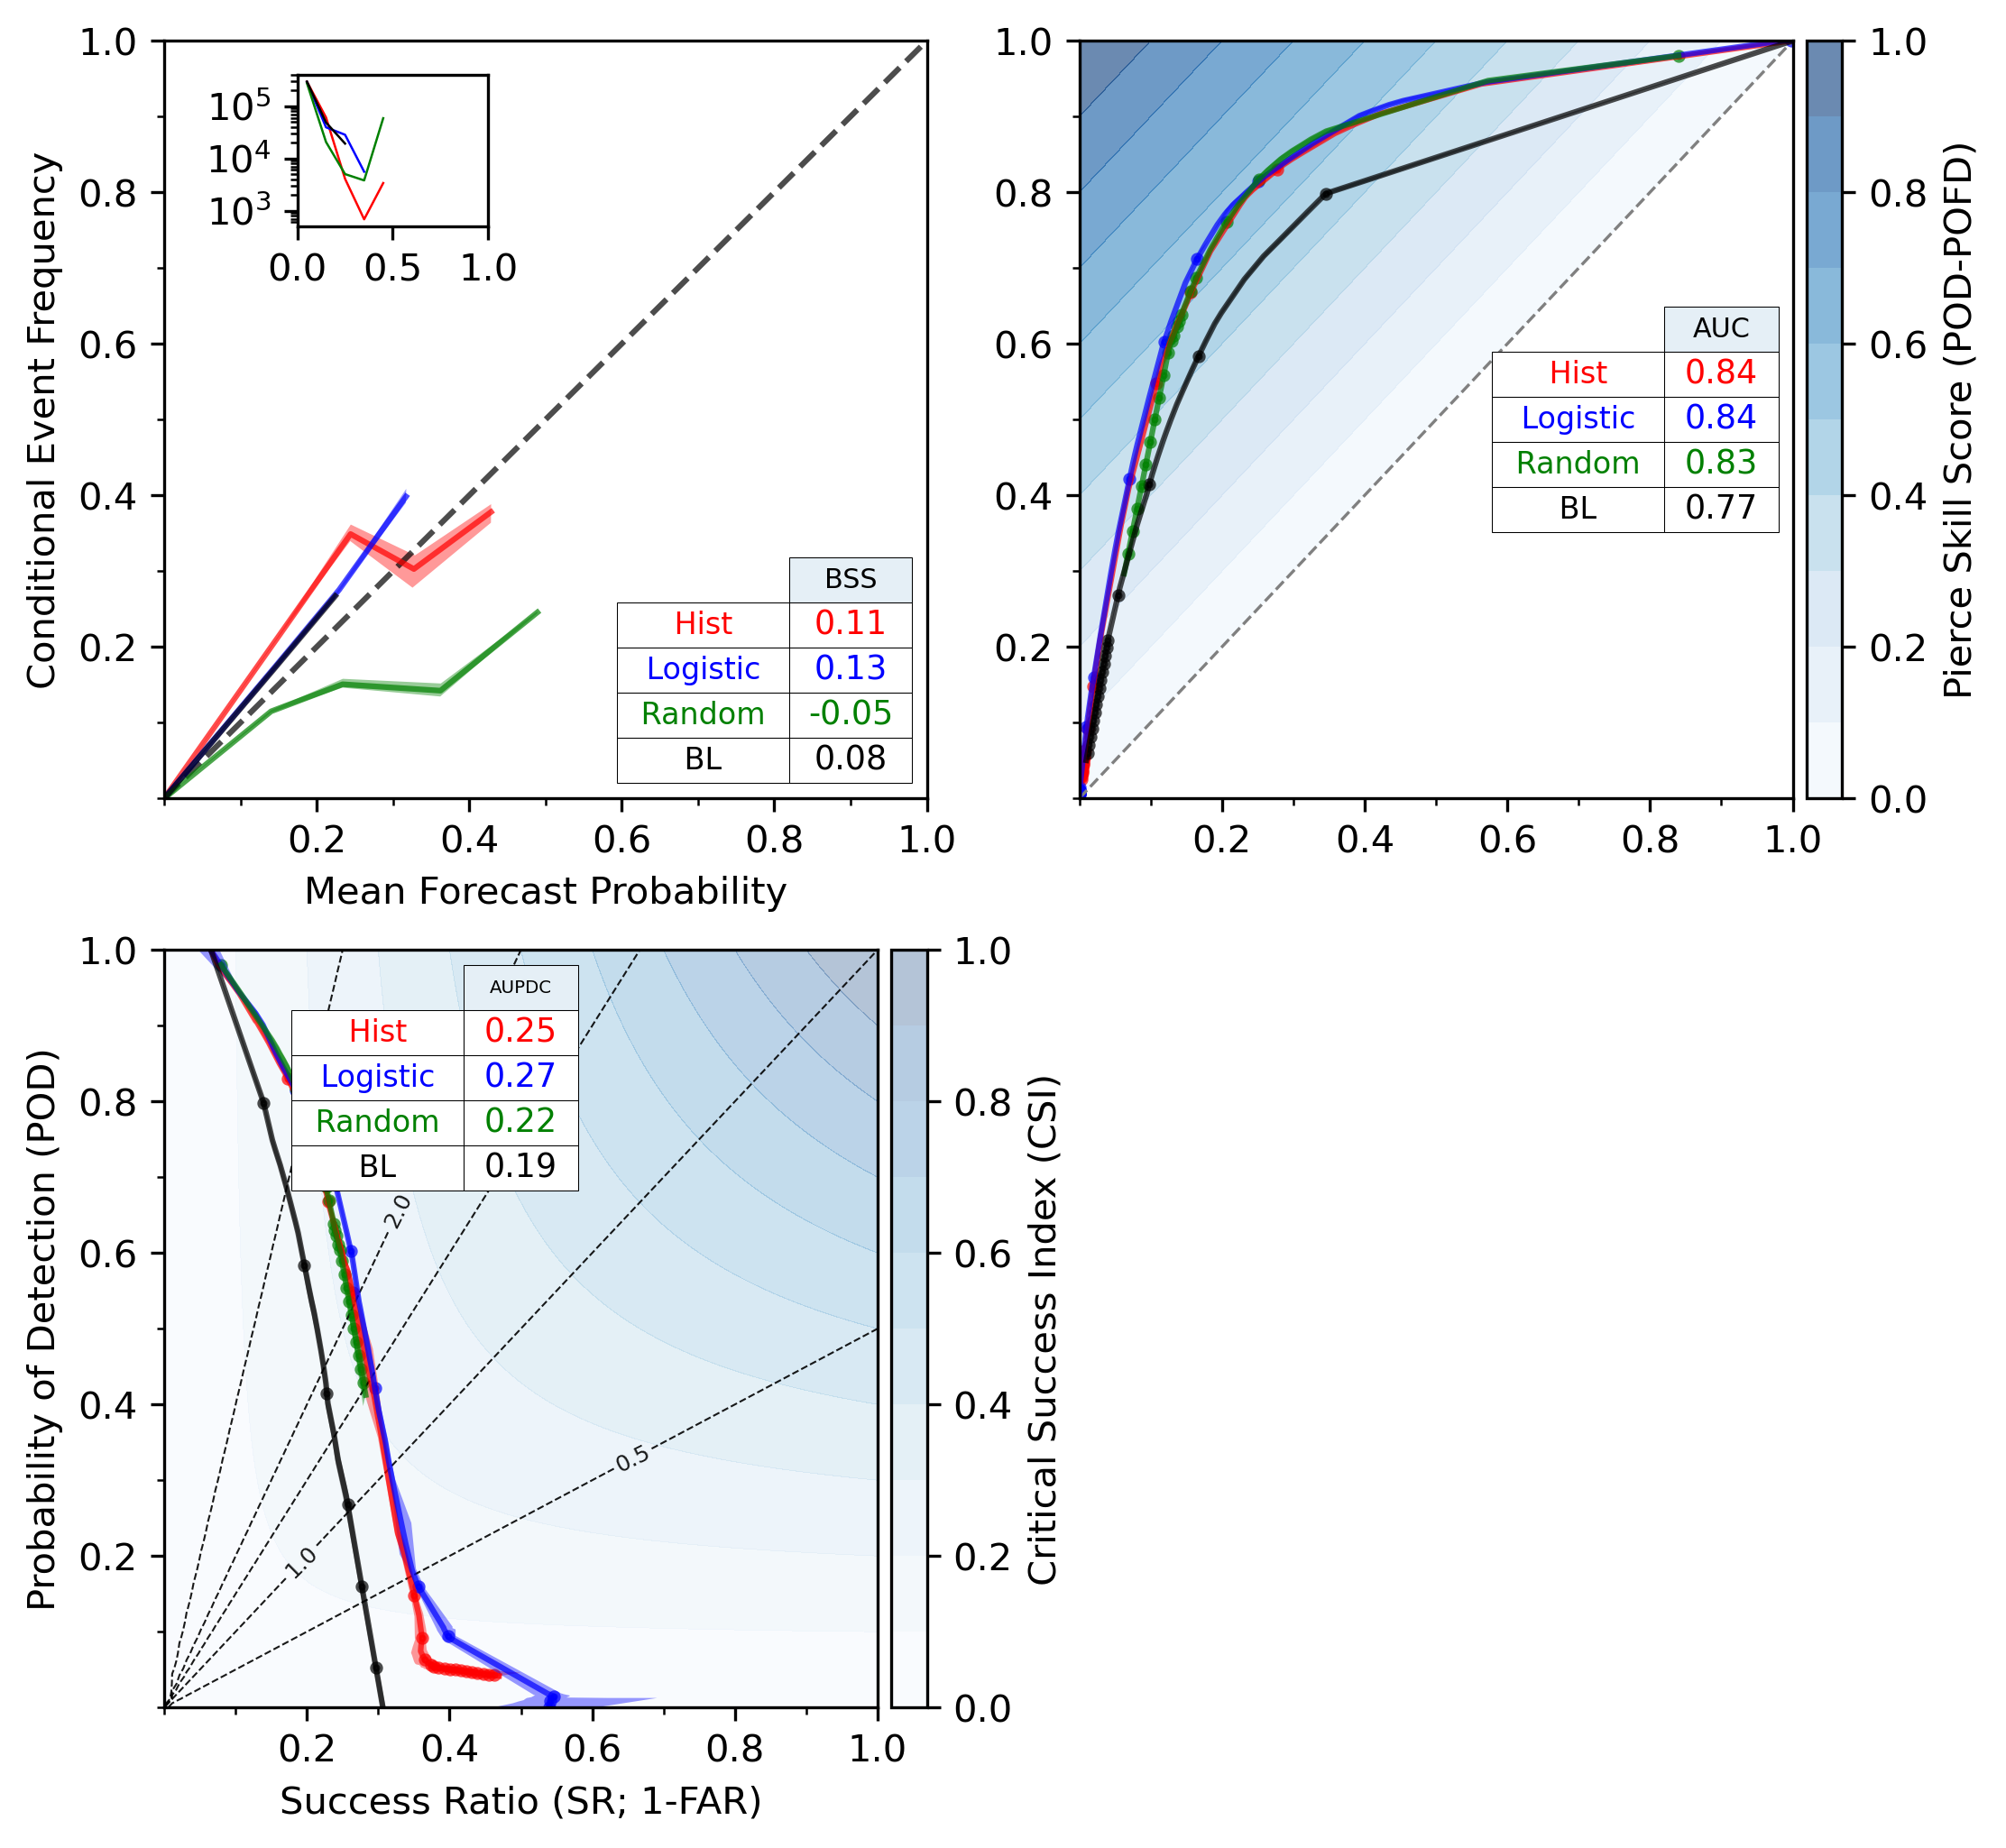

In [19]:
# Since X_bl and y are dataframe, we convert them to numpy.arrays 
# by using .values method. 
plot_verification(estimators = estimators, 
                  baseline_estimators = [('BL', bl_model)], 
                  X = X, 
                  X_baseline = X_bl.values, 
                  y=y.values,
                  n_boot=10
                 )

# Uncomment and modify the filename to save the figure. 
#plt.savefig(f'{target_col}.png')

In [20]:
print(np.mean(y))

0.06530558431962821


# Step 4. Create a Contingency Table

In [21]:
#Truth is x, prediction is y, positive is 0, negative is 1